In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

#import lightgbm as lgb
import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

https://www.kaggle.com/smiles28/tps10-optuna-xgb-catb-lgbm-stacking

ver6 xgb1

# Parameters

In [2]:
target = 'target'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 5
    N_ESTIMATORS = 20000
    EARLY_STOPPING_ROUNDS = 500
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-oct-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")

In [5]:
train = train[train.columns[1:]]
test = test[test.columns[1:]]

# Preprocessing

In [6]:
features = [col for col in train.columns if 'f' in col]

In [7]:
train["mean"] = train[features].mean(axis=1)
train["std"] = train[features].std(axis=1)
train["min"] = train[features].min(axis=1)
train["max"] = train[features].max(axis=1)

test["mean"] = test[features].mean(axis=1)
test["std"] = test[features].std(axis=1)
test["min"] = test[features].min(axis=1)
test["max"] = test[features].max(axis=1)

features = features + ['mean', 'std', 'min', 'max']

In [8]:
cat_cols = train[features].columns[(train[features].nunique() < 5)]
con_cols = train[features].columns[(train[features].nunique() >= 5)]
cat_cols_indices = [train[features].columns.get_loc(col) for col in cat_cols]
print(f"cat_cols: {cat_cols}")

cat_cols: Index(['f22', 'f43', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248',
       'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257',
       'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266',
       'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275',
       'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284',
       'min', 'max'],
      dtype='object')


In [9]:
scaler = StandardScaler()

train[con_cols] = pd.DataFrame(columns=con_cols, data=scaler.fit_transform(train[con_cols]))
test[con_cols] = pd.DataFrame(columns=con_cols, data=scaler.transform(test[con_cols]))

In [10]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
    
            # test if column can be converted to an integer
            asint = props[col].astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props

In [11]:
train = reduce_mem_usage(train)
test  = reduce_mem_usage(test)

Memory usage of properties dataframe is : 2212.5245361328125  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  968.9332275390625  MB
This is  43.79310654934584 % of the initial size
Memory usage of properties dataframe is : 1102.4476318359375  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  483.9898376464844  MB
This is  43.90139029465575 % of the initial size


In [12]:
test[features]

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f279,f280,f281,f282,f283,f284,mean,std,min,max
0,-0.677383,-0.242816,-0.985247,-1.195697,-1.652015,-1.586751,-1.234930,1.289721,0.929646,0.720009,...,0,0,1,1,1,0,0.234938,0.713578,0,1
1,-0.620481,0.160259,-0.884402,0.087831,0.150076,-1.152499,-0.772270,1.023922,-1.493109,-0.417006,...,0,0,0,0,0,0,-0.717136,-0.848016,0,1
2,-1.024253,-0.088991,1.079392,1.388078,0.120719,-0.053533,-1.028151,-0.192132,-0.395183,-0.093546,...,0,0,1,0,0,0,0.587046,0.987172,0,1
3,-0.598463,0.599685,-0.280695,0.793873,1.396931,-0.994456,-0.872602,-0.816411,-1.270981,-0.043680,...,0,1,1,0,0,0,0.815102,0.387856,0,1
4,0.281231,-1.220983,-0.875313,0.369118,0.763212,1.115671,1.192359,0.199376,0.647326,-0.464385,...,1,0,0,1,0,0,-0.059900,0.193448,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,-0.541280,0.642739,-0.946219,-1.164745,-0.708815,0.262982,0.629577,1.172683,-0.078199,-0.393215,...,0,0,1,0,0,0,-1.011832,-1.211808,0,1
499996,-0.584022,0.918391,-1.003251,0.048331,0.484493,1.055669,0.478465,-1.108239,0.425020,-0.276404,...,0,0,0,1,0,0,-0.571106,-0.366257,0,1
499997,-0.556715,0.724710,-0.977074,-1.208552,1.213713,0.966301,0.306746,-1.006763,-1.687109,1.301561,...,0,0,0,0,0,0,0.170697,0.016326,0,1
499998,0.251260,0.523399,0.408509,0.572796,0.736491,-0.261961,-1.522311,0.819159,0.872066,-0.883931,...,0,0,1,0,0,0,-2.531486,-3.519996,0,1


In [13]:
train[target]

0         1
1         1
2         1
3         1
4         1
         ..
999995    1
999996    0
999997    0
999998    1
999999    0
Name: target, Length: 1000000, dtype: uint8

In [14]:
del cat_cols
del cat_cols_indices
del con_cols
del scaler

gc.collect()

40

# XGB

In [15]:
xgb_params = {
     'objective': 'binary:logistic',
     'n_estimators':N_ESTIMATORS,
     'importance_type': 'total_gain',
     #'booster': 'gbtree',
     'n_jobs' : -1,
     'tree_method': 'hist',
        
    'learning_rate': 8e-3,
    'subsample': 0.6,
    'colsample_bytree': 0.4,
    'reg_lambda': 32, 
    'reg_alpha': 64, 
    'min_child_weight': 8,
    'max_depth': 8, 
    
    'colsample_bylevel': 0.9,
}

In [16]:
xgb_oof = np.zeros(train.shape[0])
xgb_pred = np.zeros(test.shape[0])
xgb_importances = pd.DataFrame()

X_test = test[features]
del test
gc.collect()


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED+4]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")
    if fold >2:
        
        X_train = train[features].iloc[trn_idx]
        y_train = train[target].iloc[trn_idx]
        X_valid = train[features].iloc[val_idx]
        y_valid = train[target].iloc[val_idx]
        


        start = time.time()
        for inseed in seed_list:
            xgb_params['random_state'] = inseed

            pre_model = xgb.XGBClassifier(**xgb_params)
            pre_model.fit(
                X_train, 
                y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric='auc',
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
            )

            xgb_params2 = xgb_params.copy()
            xgb_params2['reg_lambda'] *= 0.9
            xgb_params2['reg_alpha'] *= 0.9
            xgb_params2['learning_rate'] *= 0.1
            model = xgb.XGBClassifier(**xgb_params2)
            model.fit(
                    X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    eval_metric='auc',
                    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                    verbose=VERBOSE,
                    xgb_model=pre_model
            )    

            with open(f"xgb_model{fold}_seed{inseed}.pkl", 'wb') as f:
                pickle.dump(model, f)

            fi_tmp = pd.DataFrame()
            fi_tmp['feature'] = X_train.columns
            fi_tmp['importance'] = model.feature_importances_
            fi_tmp['fold'] = fold
            fi_tmp['seed'] = inseed
            xgb_importances = xgb_importances.append(fi_tmp)

            xgb_oof[val_idx] += model.predict_proba(X_valid)[:,-1] / len(seed_list)
            xgb_pred += model.predict_proba(X_test)[:,-1] / len(seed_list)
            
            del pre_model
            del model
            gc.collect()


        elapsed = time.time() - start
        auc = roc_auc_score(y_valid, xgb_oof[val_idx])
        print(f"fold {fold} - xgb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")
        
        del X_train
        del y_train
        del X_valid
        del y_valid
        gc.collect()


del X_test
gc.collect()

xgb_pred /= N_SPLITS
print(f"oof xgb_auc = {roc_auc_score(train[target], xgb_oof)}")

np.save("xgb_oof.npy", xgb_oof)
np.save("xgb_pred.npy", xgb_pred)

===== fold 0 =====
===== fold 1 =====
===== fold 2 =====
===== fold 3 =====
[0]	validation_0-auc:0.62019
[1000]	validation_0-auc:0.84846
[2000]	validation_0-auc:0.85325
[3000]	validation_0-auc:0.85508
[4000]	validation_0-auc:0.85591
[5000]	validation_0-auc:0.85627
[6000]	validation_0-auc:0.85642
[7000]	validation_0-auc:0.85649
[8000]	validation_0-auc:0.85651
[8415]	validation_0-auc:0.85650
[0]	validation_0-auc:0.85650
[1000]	validation_0-auc:0.85650
[1099]	validation_0-auc:0.85650
fold 3 - xgb auc: 0.856587, elapsed time: 8530.20sec

===== fold 4 =====
[0]	validation_0-auc:0.61974
[1000]	validation_0-auc:0.84873
[2000]	validation_0-auc:0.85339
[3000]	validation_0-auc:0.85515
[4000]	validation_0-auc:0.85590
[5000]	validation_0-auc:0.85623
[6000]	validation_0-auc:0.85636
[7000]	validation_0-auc:0.85640
[7373]	validation_0-auc:0.85641
[0]	validation_0-auc:0.85641
[1000]	validation_0-auc:0.85642
[2000]	validation_0-auc:0.85642
[3000]	validation_0-auc:0.85644
[3456]	validation_0-auc:0.85643

# OOF predictions

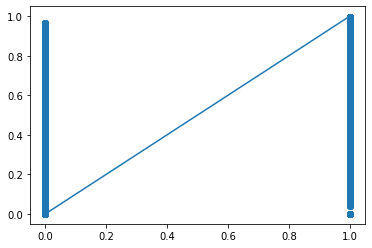

In [17]:
plt.plot(train[target], train[target])
plt.scatter(train[target], xgb_oof)

In [18]:
del train
del xgb_oof
gc.collect()

20

# Features importances

Text(0.5, 1.0, 'XGB feature importances')

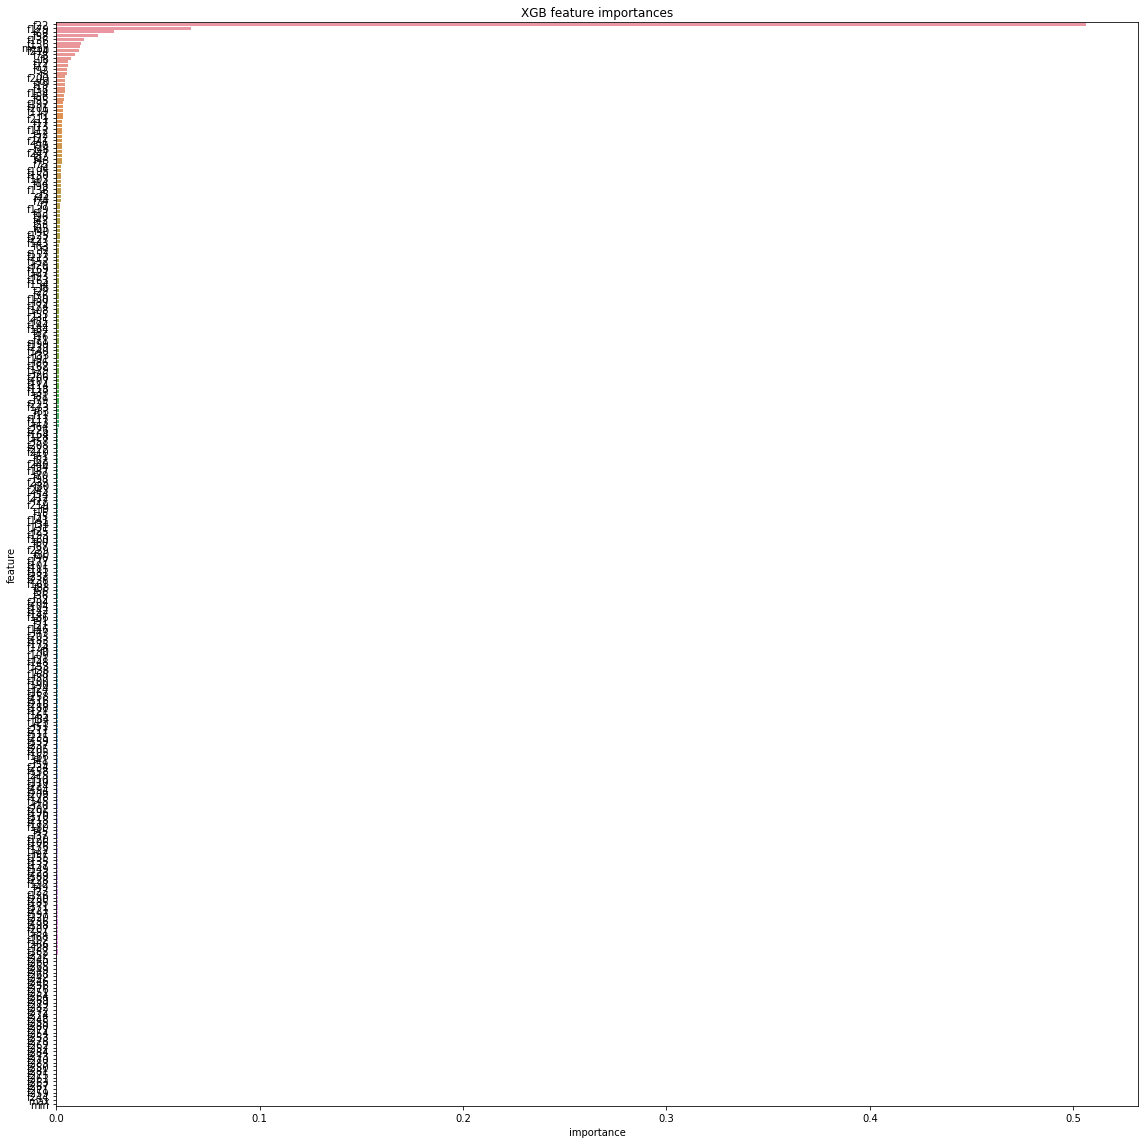

In [19]:
order = list(xgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=xgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("XGB feature importances")

# Submission

In [20]:
submission[target] = xgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,target
0,1000000,0.275433
1,1000001,0.097503
2,1000002,0.365732
3,1000003,0.330921
4,1000004,0.109128
...,...,...
499995,1499995,0.391384
499996,1499996,0.340512
499997,1499997,0.126231
499998,1499998,0.210996


# Log

seeds

2017 ver2 fold 0-2 ver3 fold 3-4 

2018 ver4 fold 0-2 ver5 fold 3-4

2019 ver6 fold 0-2 ver7 fold 3-4

2020 ver8 fold 0-2 ver9 fold 3-4

2021 ver10 fold 0-2 ver11 fold 3-4
